In [1]:
import pandas as pd
import numpy as np
import json
from ast import literal_eval
import matplotlib.pyplot as plt
from datetime import datetime
import collections, functools, operator
import re
import matplotlib.ticker as mtick
from matplotlib.lines import Line2D
from scipy import stats
from scipy.special import rel_entr
import statsmodels.api as sm

months = ['January', 'February', 'March', 'April', 'May', 'June', 'July',
              'August', 'September', 'October', 'November', 'December']

### Load the data

In [2]:
def slicePlaceType(df_test, df_base, place_types_list=[]):
    """ Slice function for separating places into place types and calculating the occupancy
    :param df_test: the dataframe with the data for the current month
    :param df_base: the dataframe with the data for the baseline month
    :param place_types_list: the list of place types to be sliced. If left empty it returns all
                             placetypes present in df_test AND df_base
    :return dict_df: a dictionary with keys corresponding to all the place types and values corresponding to the dataframes
    """
    dict_df = {}
    if not place_types_list:
        place_types_list_1 = list(df_test['top_category'].unique())
        place_types_list_2 = list(df_base['top_category'].unique())
        place_types = [value for value in place_types_list_1 if value in place_types_list_2 and str(value) != 'nan']
    else: place_types = place_types_list
    
    for placeType in place_types:
        df = df_test[df_test['top_category'].str.contains(placeType, na=False)][['safegraph_place_id', 'top_category', 'sub_category', 'naics_code', 'popularity_by_day']]
        df = pd.merge(df, df_base[df_base['top_category'].str.contains(placeType, na=False)][['safegraph_place_id', 'popularity_by_day']], on='safegraph_place_id')
        df['popularity_by_day_x'] = df['popularity_by_day_x'].apply(lambda x: np.sum(list(literal_eval(x).values())))
        df['popularity_by_day_y'] = df['popularity_by_day_y'].apply(lambda x: np.sum(list(literal_eval(x).values())))
        df['occupancy'] = df['popularity_by_day_x']/df['popularity_by_day_y']*100
        dict_df[placeType] = df
    
    return dict_df

def make_plots(dict_df, keys, place_types_list):
    for pl_key in place_types_list:
        plt.figure(figsize=(18,6))
        for key in keys[1:]:
            if key not in ['2020_03', '2020_04']:
                tag = [datetime.strptime(key, '%Y_%m').strftime('%B %Y') for key in keys]
                plt.hist(dict_df[key][pl_key][dict_df[key][pl_key]['occupancy'] < 300].occupancy, bins=100, label=tag, histtype='step', linewidth=3)
        plt.hist(dict_df['2020_03'][pl_key][dict_df['2020_03'][pl_key]['occupancy'] < 300].occupancy, bins=100, label=tag, linewidth=3, alpha=0.7)
        plt.hist(dict_df['2020_04'][pl_key][dict_df['2020_04'][pl_key]['occupancy'] < 300].occupancy, bins=100, label=tag, linewidth=3, alpha=0.7)
        plt.xlabel('% occupancy (baseline: April 2019)', fontsize=16)
        plt.ylabel('number of places', fontsize=16)
        plt.title(pl_key + ' in New York City', fontsize=18)
        plt.grid(':', alpha=0.7)
        plt.xlim((-0.1, 200))
        plt.legend()
        plt.show()
        
        
def getData(df_i, place_type):
    data_2019 = []
    data_2020 = []
    for key in keys:
        df = df_i[key][place_type]
        if '2019' in key:
            data_2019.append(df[df.occupancy < 200].occupancy.values)
        else:
            data_2020.append(df[df.occupancy < 200].occupancy.values)
    return data_2019, data_2020


def makeViolin(df, df_un, title, filename, place_type):
    data_1, data_2 = getData(df, place_type)
    
    months = ['January', 'February', 'March', 'April', 'May', 'June', 'July',
              'August', 'September', 'October', 'November', 'December']

    fig, host = plt.subplots(figsize=(18,5))

    ax = plt.gca()
    parts = ax.violinplot(data_1,
                  widths=0.7,
                  showextrema=False,
                  showmeans=False,
                 )

    for pc in parts['bodies']:
        pc.set_facecolor('#3f7f93')
        pc.set_edgecolor('#28515d')
        pc.set_alpha(0.2)
        pc.set_linewidth(1.5)

    parts = ax.violinplot(data_2,
                  widths=0.7,
                  showextrema=False,
                  showmeans=False,
                 )

    for pc in parts['bodies']:
        pc.set_facecolor('#da3b46')
        pc.set_edgecolor('#670000')
        pc.set_alpha(0.2)
        pc.set_linewidth(1.5)

    plt.ylim(0, 200)
    plt.xlim(0, 14)
    ax.set_xticks(list(range(1,13)))
    ax.set_xticklabels([month+'\n' for month in months], rotation="vertical", fontsize=16, fontdict={'verticalalignment': 'center'}, zorder=99)
    ax.tick_params(axis="x", direction="in", pad=-250, length=0)
    ax.tick_params(axis="y", labelsize=14)
    plt.title(title, fontsize=18)
    plt.locator_params(axis='y', nbins=8)

    labels = ['2019', '2020']
    ax.yaxis.set_major_formatter(mtick.PercentFormatter())
    line2 = Line2D([0], [0], color='#da3b46', linewidth=10, linestyle='-', solid_capstyle='butt', alpha=0.4)
    line1 = Line2D([0], [0], color='#3f7f93', linewidth=10, linestyle='-', solid_capstyle='butt', alpha=0.4)
    leg1 = plt.figlegend(handles=[line1, line2], labels=labels, bbox_to_anchor=[0.947, 0.92],
                        loc='upper right', prop={'size': 14}, fancybox=True, framealpha=1, columnspacing=0.8, ncol=1, handletextpad=0.3, title='occupancy')
    leg1.get_title().set_fontsize(14)
    plt.ylabel(r"occupancy (normalized by January 2019)", fontsize=16)

    unemp = host.twinx()
    unemp.set_ylim(0,32)
    ax = plt.gca()
    ax.yaxis.set_major_formatter(mtick.PercentFormatter())
    ax.tick_params(axis="y", labelsize=14)
    unemp.set_ylabel(r"unemployment", fontsize=16, rotation='-90', labelpad=20)
    unemp.scatter(list(range(1,13)), df_un.values[:12], color="#3f7f93", s=100, alpha=0.8, edgecolors="#28515d", label="2019")
    unemp.scatter(list(range(1,13)), df_un.values[12:], color="#da3b46", s=100, alpha=0.8, edgecolors="#670000", label="2020")
    plt.yticks([0,4,8,12,16,20,24,28,32], ['0%','4%','8%','12%','16%','20%','24%','28%','32%'])
    leg2 = plt.legend(loc='lower right', fontsize=14, handletextpad=0, title='unemployment')
    leg2.get_title().set_fontsize(14)
    ax.add_artist(leg1)

    ax.grid(linestyle=':', axis='y', alpha=0.7)
    plt.tight_layout()
    plt.savefig(filename, dpi=300)
    plt.show()
    
def getKL(df, place_type, p=False):
    result = []
    for i, val in enumerate(months):
        if i != 0:
            a_2019_res = df['2019_'+str(i+1).zfill(2)][place_type]['occupancy'].values
            a_2020_res = df['2020_'+str(i+1).zfill(2)][place_type]['occupancy'].values
            x1 = a_2019_res[a_2019_res < 200]
            x2 = a_2020_res[a_2020_res < 200]
            kde1 = stats.gaussian_kde(x1)
            kde2 = stats.gaussian_kde(x2)
            x_eval = np.linspace(0, 200, num=1000)
            if p: print("{axis:\""+val+"\", value:{}".format(stats.entropy(kde2(x_eval), kde1(x_eval)))+"},")
            result.append(stats.entropy(kde2(x_eval), kde1(x_eval)))
        else:
            if p: print("{axis:\""+val+"\", value:{}".format(0)+"},") 
            result.append(0)
    return result
        
        
def getOccupancyDistribution(city):
    keys = ['2019_01', '2019_02', '2019_03', '2019_04', '2019_05', '2019_06', '2019_07', '2019_08', '2019_09', '2019_10', '2019_11', '2019_12',
        '2020_01', '2020_02', '2020_03', '2020_04', '2020_05', '2020_06', '2020_07', '2020_08', '2020_09', '2020_10', '2020_11', '2020_12',]

    dict_df = {}
    dict_df_city = {}

    for key in keys:
        dict_df[key] = pd.read_csv('../datasets/'+city+'/'+city+'_'+key+'.csv.tar.gz', compression='gzip')

    dfC_2020_04 = pd.read_csv('../datasets/'+city+'/Core-'+city+'_2020_04.csv.tar.gz', compression='gzip')

    for key in keys:
        dict_df_city[key] = pd.merge(dfC_2020_04[['safegraph_place_id', 'top_category', 'sub_category', 'naics_code']],
                                    dict_df[key], on='safegraph_place_id')


    place_types_list = ['Restaurants', 'Grocery', 'Clothing Stores']
    dict_df_analysis_city = {}
    for key in keys:
        dict_df_analysis_city[key] = slicePlaceType(dict_df_city[key], dict_df_city['2019_01'], place_types_list)
    return dict_df_analysis_city

def getUnemp(city, p=False):
    result = []
    for i, val in enumerate(months):
        if p: print("{axis:\""+val+"\", value:{}".format(np.clip(df_unemp[city].values[i+12] - df_unemp[city].values[i], 0, 100))+"},")
        result.append(df_unemp[city].values[i+12] - df_unemp[city].values[i])
    return result

_______________________
## Get the data for NYC

In [13]:
keys = ['2019_01', '2019_02', '2019_03', '2019_04', '2019_05', '2019_06', '2019_07', '2019_08', '2019_09', '2019_10', '2019_11', '2019_12',
        '2020_01', '2020_02', '2020_03', '2020_04', '2020_05', '2020_06', '2020_07', '2020_08', '2020_09', '2020_10', '2020_11', '2020_12',]

# keys = ['2019_04', '2019_05', '2019_06', '2019_07', '2019_08', '2019_09', '2019_10', '2019_11', '2019_12',
#         '2020_01', '2020_02', '2020_03', '2020_04', '2020_05', '2020_06', '2020_07', '2020_08', '2020_09', '2020_10', '2020_11', '2020_12', 
#         '2021_01', '2021_02', '2021_03']
dict_df = {}
dict_df_NYC = {}

for key in keys:
    dict_df[key] = pd.read_csv('../datasets/NYC/NYC_'+key+'.csv.tar.gz', compression='gzip')
    
dfC_2020_04 = pd.read_csv('../datasets/NYC/Core-NYC_2020_04.csv.tar.gz', compression='gzip')

for key in keys:
    dict_df_NYC[key] = pd.merge(dfC_2020_04[dfC_2020_04['city']=='New York'][['safegraph_place_id', 'top_category', 'sub_category', 'naics_code', 'latitude', 'longitude']],
                                dict_df[key][dict_df[key]['city']=='New York'], on='safegraph_place_id')
    

dump = False
if dump:
    with open('../datasets/place_types.json', 'w') as f:
        json.dump(pd.DataFrame(np.sort(dict_df_NYC[keys[0]]['top_category'].dropna().unique()), columns=["place_type"]).to_dict(orient='dict'), f, indent=4)
    
with open('../datasets/place_types.json', 'r') as f:
    place_types = json.load(f)
    

place_types_list = ['Restaurants', 'Grocery', 'Clothing Stores']
dict_df_analysis_NYC = {}
for key in keys:
    dict_df_analysis_NYC[key] = slicePlaceType(dict_df_NYC[key], dict_df_NYC['2019_01'], place_types_list)

In [31]:
df = dict_df_NYC['2019_01']
df.keys()

False

In [26]:
df[df['safegraph_place_id'] == 'sg:15d70e431d9c41ab960269564bcb69f9']['latitude'].values[0]

40.782916

In [4]:
df_unemp = pd.read_csv('../datasets/unemployment-2019-2021.csv')
df_unemp['NYC'] = df_unemp[['New York', 'Kings', 'Bronx', 'Richmond', 'Queens']].mean(axis=1)

In [5]:
for i in ['01', '02','03','04','05','06','07','08','09','10','11','12']:
    df1 = dict_df_analysis_NYC['2019_'+i]['Restaurants'][['safegraph_place_id', 'popularity_by_day_x']].rename(columns={'popularity_by_day_x':'popularity_2019'})
    df2 = dict_df_analysis_NYC['2020_'+i]['Restaurants'][['safegraph_place_id', 'popularity_by_day_x']].rename(columns={'popularity_by_day_x':'popularity_2020'})
    df_merge = pd.merge(df1, df2, on='safegraph_place_id')
    df_merge['occupancy'] = df2['popularity_2020']/df1['popularity_2019']*100
    df_merge = df_merge[(df_merge['occupancy'] < 200)]
    x1 = df_merge['popularity_2019'].values
    x2 = df_merge['popularity_2020'].values

    x_max = max(np.max(x1), np.max(x2))
    kde1 = stats.gaussian_kde(x1)
    kde2 = stats.gaussian_kde(x2)
    x_eval = np.linspace(0, x_max, num=2000)

    print(stats.entropy(kde2(x_eval), kde1(x_eval)), stats.entropy(x2, x1))

0.016409936963861886 0.050811063582172265
0.0237748150715504 0.04954259805823854
0.29645727330952365 0.08020739659608428
1.5120317185766803 0.38997465995181224
1.2013855530614674 0.34970991111713806
0.9140466572809236 0.30110280300137593
0.7071881055002661 0.26696120177598404
0.5943639254307962 0.2168028547578771
0.647316845225939 0.19902402819015044
0.5715087146401627 0.19300178931419348
inf 0.4082764318210774
0.7752609171604808 0.2400974826576289


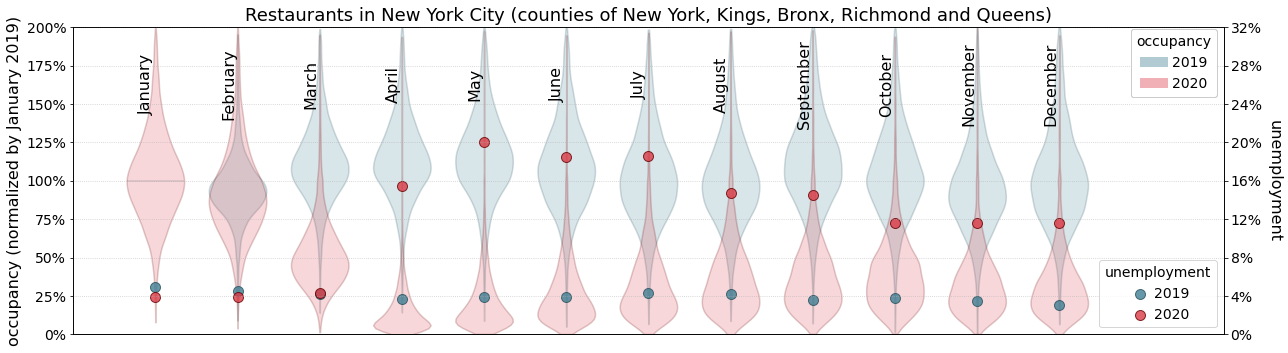

In [353]:
title = 'Restaurants in New York City (counties of New York, Kings, Bronx, Richmond and Queens)'
filename = '../plots/NYC-Restaurants.png'
unemp_data = df_unemp.NYC

makeViolin(dict_df_analysis_NYC, unemp_data, title, filename, 'Restaurants')

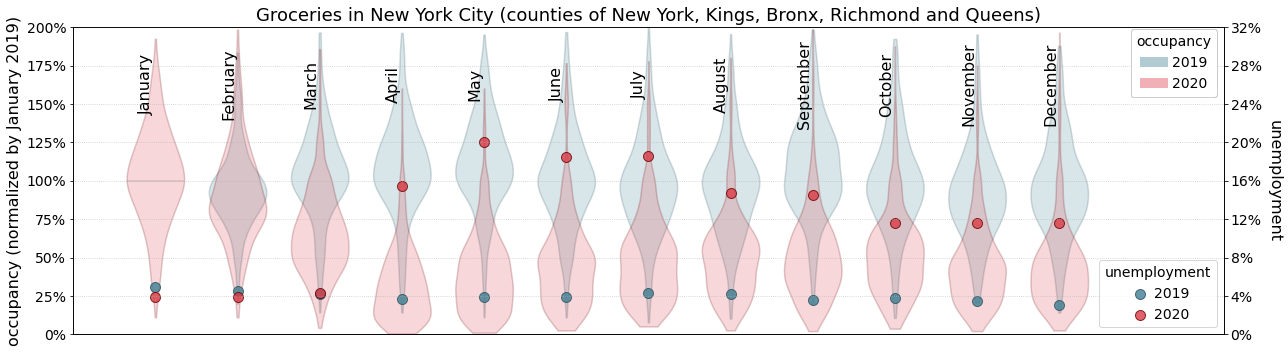

In [354]:
title = 'Groceries in New York City (counties of New York, Kings, Bronx, Richmond and Queens)'
filename = '../plots/NYC-Groceries.png'
unemp_data = df_unemp.NYC

makeViolin(dict_df_analysis_NYC, unemp_data, title, filename, 'Grocery')

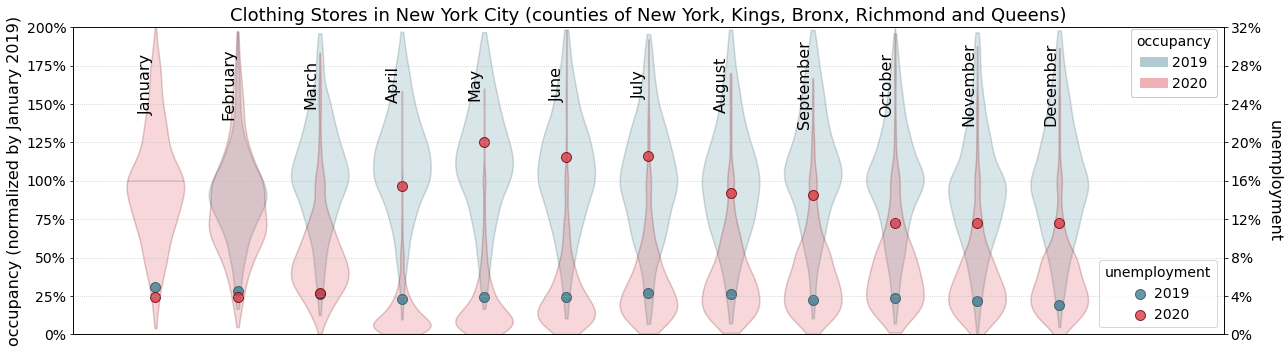

In [355]:
title = 'Clothing Stores in New York City (counties of New York, Kings, Bronx, Richmond and Queens)'
filename = '../plots/NYC-Clothing_Stores.png'
unemp_data = df_unemp.NYC

makeViolin(dict_df_analysis_NYC, unemp_data, title, filename, 'Clothing Stores')

____________________
## Get the data for Phoenix

In [44]:
dict_df_analysis_Phoenix = getOccupancyDistribution('Phoenix')

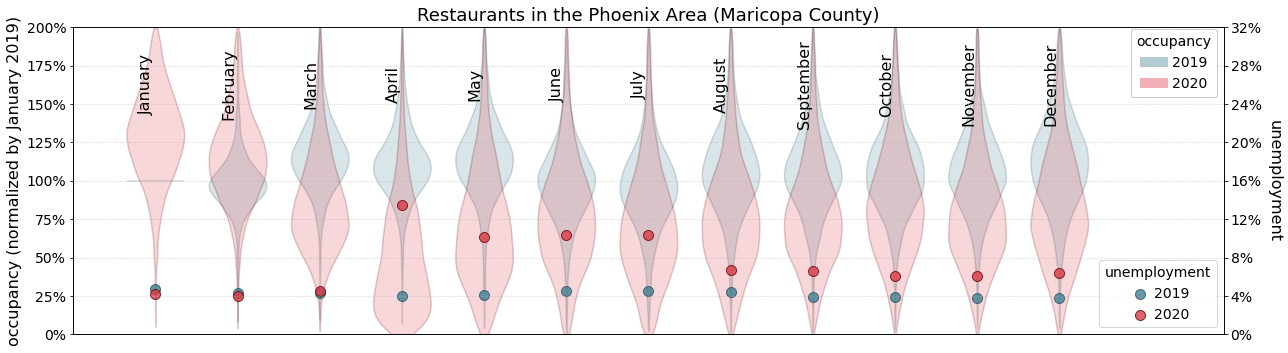

In [356]:
title = 'Restaurants in the Phoenix Area (Maricopa County)'
filename = '../plots/Phoenix-Restaurants.png'
unemp_data = df_unemp.Maricopa

makeViolin(dict_df_analysis_Phoenix, unemp_data, title, filename, 'Restaurants')

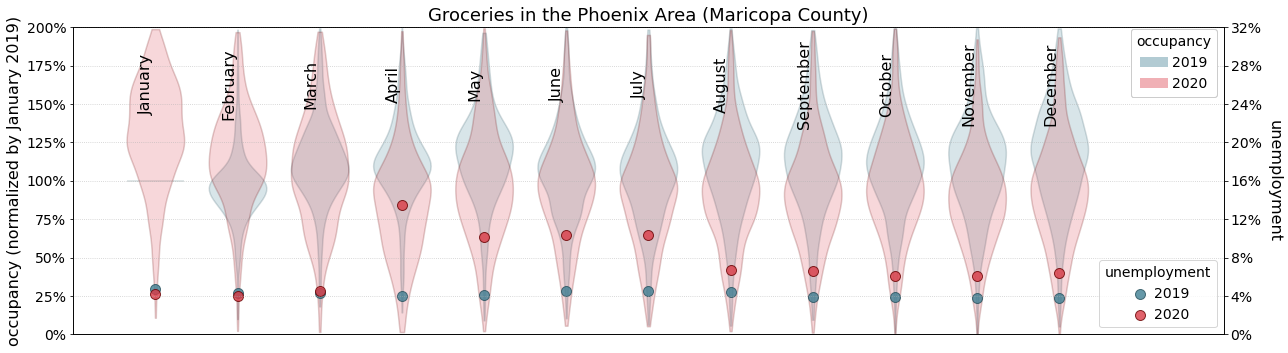

In [357]:
title = 'Groceries in the Phoenix Area (Maricopa County)'
filename = '../plots/Phoenix-Groceries.png'
unemp_data = df_unemp.Maricopa

makeViolin(dict_df_analysis_Phoenix, unemp_data, title, filename, 'Grocery')

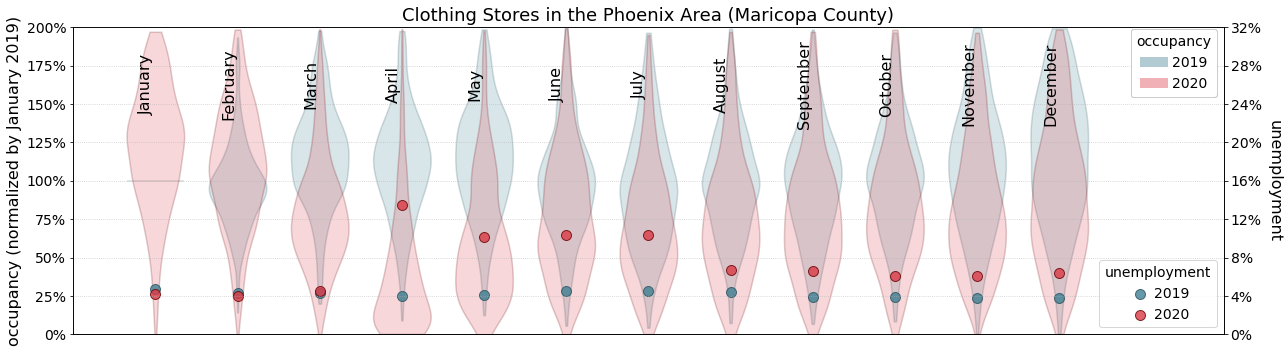

In [358]:
title = 'Clothing Stores in the Phoenix Area (Maricopa County)'
filename = '../plots/Phoenix-Clothing_Stores.png'
unemp_data = df_unemp.Maricopa

makeViolin(dict_df_analysis_Phoenix, unemp_data, title, filename, 'Clothing Stores')

____________________
## Get the data for Houston

In [48]:
dict_df_analysis_Houston = getOccupancyDistribution('Houston')

____________________
## Get the data for Los Angeles

In [50]:
dict_df_analysis_LosAngeles = getOccupancyDistribution('LosAngeles')

____________________
## Get the data for Chicago

In [57]:
dict_df_analysis_Chicago = getOccupancyDistribution('Chicago')

In [ ]:
df_res_KL = pd.DataFrame()
df_res_KL['New York'] = getKL(dict_df_analysis_NYC, 'Restaurants')
df_res_KL['Los Angeles'] = getKL(dict_df_analysis_LosAngeles, 'Restaurants')
df_res_KL['Chicago'] = getKL(dict_df_analysis_Chicago, 'Restaurants')
df_res_KL['Houston'] = getKL(dict_df_analysis_Houston, 'Restaurants')
df_res_KL['Phoenix'] = getKL(dict_df_analysis_Phoenix, 'Restaurants')

In [121]:
df_gros_KL = pd.DataFrame()
df_gros_KL['New York'] = getKL(dict_df_analysis_NYC, 'Grocery')
df_gros_KL['Los Angeles'] = getKL(dict_df_analysis_LosAngeles, 'Grocery')
df_gros_KL['Chicago'] = getKL(dict_df_analysis_Chicago, 'Grocery')
df_gros_KL['Houston'] = getKL(dict_df_analysis_Houston, 'Grocery')
df_gros_KL['Phoenix'] = getKL(dict_df_analysis_Phoenix, 'Grocery')

In [122]:
df_CS_KL = pd.DataFrame()
df_CS_KL['New York'] = getKL(dict_df_analysis_NYC, 'Clothing Stores')
df_CS_KL['Los Angeles'] = getKL(dict_df_analysis_LosAngeles, 'Clothing Stores')
df_CS_KL['Chicago'] = getKL(dict_df_analysis_Chicago, 'Clothing Stores')
df_CS_KL['Houston'] = getKL(dict_df_analysis_Houston, 'Clothing Stores')
df_CS_KL['Phoenix'] = getKL(dict_df_analysis_Phoenix, 'Clothing Stores')

### Unemployment

In [124]:
df_ue = pd.DataFrame()
df_ue['New York'] = getUnemp('NYC')
df_ue['Los Angeles'] = getUnemp('Los Angeles')
df_ue['Chicago'] = getUnemp('Cook')
df_ue['Houston'] = getUnemp('Harris')
df_ue['Phoenix'] = getUnemp('Maricopa')

In [331]:
df_all = pd.DataFrame()
df_all['Restaurants'] = np.log(df_res_KL.to_numpy().flatten()[5:])
df_all['Grocery'] = np.log(df_gros_KL.to_numpy().flatten()[5:])
df_all['Clothing Stores'] = np.log(df_CS_KL.to_numpy().flatten()[5:])
df_all['Unemployment'] = df_ue.to_numpy().flatten()[5:]

In [323]:
def makeCorrelationPlot(df, filename, place_name, m, c):
    plt.figure(figsize=(8,6))
    
    x_eval = np.linspace(-3, 2, 100)
    Y = m*x_eval + c
    plt.plot(x_eval, Y, linestyle='dashed', linewidth=2, color='#B392AC')
    
    plt.scatter(np.log(df['New York'].values[1:]), df_ue['New York'].values[1:], color='#272932', label='New York', marker='o', s=50)
    plt.scatter(np.log(df['Los Angeles'].values[1:]), df_ue['Los Angeles'].values[1:], color='#248232', label='Los Angeles', marker='*', s=50)
    plt.scatter(np.log(df['Chicago'].values[1:]), df_ue['Chicago'].values[1:], color='#F79D5C', label='Chicago', marker='^', s=50)
    plt.scatter(np.log(df['Houston'].values[1:]), df_ue['Houston'].values[1:], color='#4D7EA8', label='Houston', marker='d', s=50)
    plt.scatter(np.log(df['Phoenix'].values[1:]), df_ue['Phoenix'].values[1:], color='#FF1053', label='Phoenix', marker='v', s=50)

    ax = plt.gca()
    ax.yaxis.set_major_formatter(mtick.PercentFormatter())
    ax.tick_params(axis="y", labelsize=12)
    ax.tick_params(axis="x", labelsize=12)
    plt.ylim(-2,17)
    plt.xlim(-3,2)
    plt.grid(':', alpha=0.5)

    plt.xlabel("log of KL Divergence for " + place_name + " (2020 vs. 2019)", fontsize=16)
    plt.ylabel("Difference in Unemployment (2020 vs. 2019)", fontsize=14)
    plt.legend(loc='upper left', fontsize=12)
    plt.savefig('../plots/'+filename, dpi=300)
    plt.show()

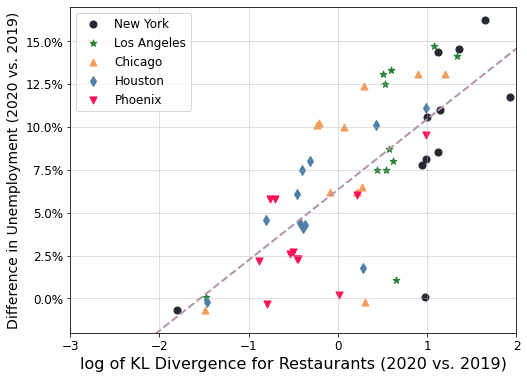

In [324]:
x = df_all['Restaurants']
y = df_all['Unemployment']
x = sm.add_constant(x)
model = sm.OLS(y, x)
results = model.fit()
r = results.params
makeCorrelationPlot(df_res_KL, 'restaurants_correlation.png', 'Restaurants', r.Restaurants, r.const)

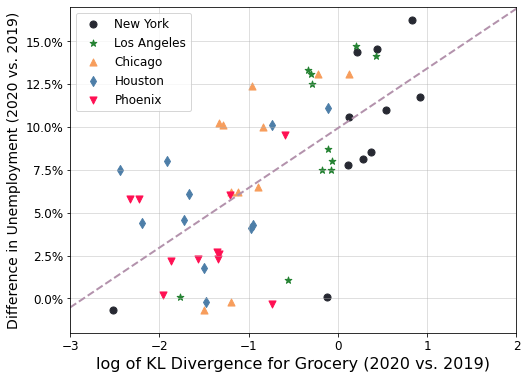

In [328]:
x = df_all['Grocery']
y = df_all['Unemployment']
x = sm.add_constant(x)
model = sm.OLS(y, x)
results = model.fit()
r = results.params
makeCorrelationPlot(df_gros_KL, 'grocery_correlation.png', 'Grocery', r.Grocery, r.const)

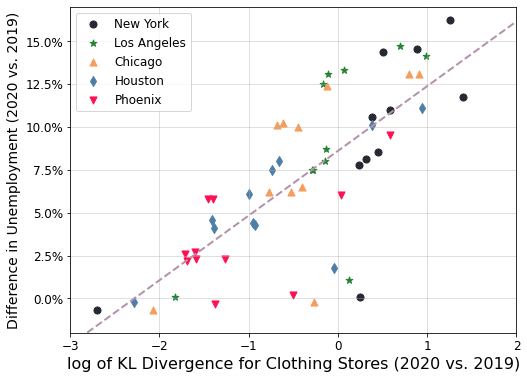

In [332]:
x = df_all['Clothing Stores']
y = df_all['Unemployment']
x = sm.add_constant(x)
model = sm.OLS(y, x)
results = model.fit()
r = results.params
makeCorrelationPlot(df_CS_KL, 'clothing_correlation.png', 'Clothing Stores', r['Clothing Stores'], r.const)

## Making some plots

In [51]:
place = 'Store'
df_tmp_1 = dict_df_Seattle['2020_12'][dict_df_Seattle['2020_12']['top_category'].str.contains(place, na=False)]
df_tmp_2 = dict_df_Seattle['2020_04'][dict_df_Seattle['2019_04']['top_category'].str.contains(place, na=False)]

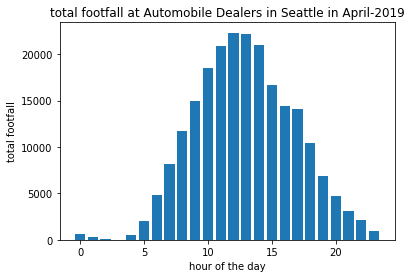

In [53]:
arr_1 = df_tmp_1['popularity_by_hour'].apply(lambda x: np.array(literal_eval(x))).sum()
arr_2 = df_tmp_2['popularity_by_hour'].apply(lambda x: np.array(literal_eval(x))).sum()
arr = arr_1#-arr_2
arr = arr - arr[np.argmin(arr)]
plt.bar(range(0,24), arr)
plt.ylabel('total footfall')
plt.xlabel('hour of the day')
plt.title('total footfall at Automobile Dealers in Seattle in April-2019')
plt.show()

In [23]:
keys = []
for year in ['2019', '2020']:
        for month in ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12']:
            keys.append(year+'_'+month)
dict_df = {}
dict_df_Seattle = {}

for key in keys:
    dict_df[key] = pd.read_csv('../datasets/SeattleMetro/SeattleMetro_'+key+'.csv.tar.gz', compression='gzip')
    
dfC_2020_04 = pd.read_csv('../datasets/SeattleMetro/Core-SeattleMetro_2020_04.csv.tar.gz', compression='gzip')

for key in keys:
    dict_df_Seattle[key] = pd.merge(dfC_2020_04[dfC_2020_04['city']=='Seattle'][['safegraph_place_id', 'top_category', 'sub_category', 'naics_code']],
                                dict_df[key][dict_df[key]['city']=='Seattle'], on='safegraph_place_id')

In [5]:
# plt.figure(figsize=(24,3))
# places = ['Drinking', 'Restaurant', 'Hospital', 'Office', 'Grocery', 'Clothing', 'Park']
places = ['Drinking']
dict_dist = {}

for i in range(len(places)):
#     plt.subplot(1,len(places),i+1)
    place = places[i]
    dict_dist[place] = {}
    df_tmp = dict_df_Seattle['2019_07'][dict_df_Seattle['2019_07']['top_category'].str.contains(place, na=False)]
    days = df_tmp['popularity_by_day'].apply(lambda x: literal_eval(x)).values
    factor_days = dict(functools.reduce(operator.add, map(collections.Counter, days)))
    factor_days = {key: (factor_days[key]/factor_days[max(factor_days, key=factor_days.get)]) for key in factor_days.keys()}
    for day in factor_days.keys():
        dict_dist[place][day] = {}
        
        arr = df_tmp['popularity_by_hour'].apply(lambda x: np.array(literal_eval(x))).sum()
        arr = (arr - arr[np.argmin(arr)])
        arr = arr/arr[np.argmax(arr)]*100*factor_days[day]
        dict_dist[place][day] = {str(i): arr[i] for i in range(len(arr))}
#     plt.bar(range(0,24), arr, label=place)
#     plt.legend()
#     plt.grid(':', axis='y', alpha=0.6)
#     plt.xlabel('hour')
#     plt.ylabel('% crowded')

# plt.tight_layout()
# plt.show()

In [37]:
with open('../datasets/place_types.json', 'r') as f:
    place_types = json.load(f)

translation = {
    'amusement_park' : ['4'],
    'bars' : ['28'],
    'bakery' : ['10'],
    'beauty' : ['88'],
    'books' : ['13'],
    'car_dealer' : ['6'],
    'car_rental' : ['7'],
    'car_repair' : ['9'],
    'casino' : ['38'],
    'church' : ['96'],
    'clothing_store' : ['18'],
    'dentist' : ['71'],
    'department_store' : ['26'],
    'doctor' : ['72','73'],
    'drugs' : ['29'],
    'electronics' : ['32'],
    'florist' : ['36'],
    'funeral_home' : ['25'],
    'furniture' : ['37'],
    'gas_station' : ['39'],
    'grocery' : ['45'],
    'gym' : ['48'],
    'hair' : ['88'],
    'hospitals' : ['87', '93', '40'],
    'hotels' : ['112'],
    'insurance' : ['3'],
    'jewelry' : ['54'],
    'laundry' : ['30'],
    'liquor' : ['11'],
    'local_govt' : ['35'],
    'museum' : ['65'],
    'post_office' : ['90'],
    'rail': ['95'],
    'real_estate': ['74'],
    'restaurants': ['98'],
    'shoe_store' : ['101'],
    'store' : ['7', '8', '13', '30', '32'],
    'school' : ['33'],
    'transportation' : ['86'],
    'travel_agency' : ['111'],
    'university' : ['19', '55']
}